In [27]:
import glob
import os
import sys
import struct
import pandas as pd
from nltk.tokenize import sent_tokenize
from tensorflow.core.example import example_pb2

sys.path.append('../src')
import data_io, params, SIF_embedding

def return_bytes(reader_obj):
    len_bytes = reader_obj.read(8)
    str_len = struct.unpack('q', len_bytes)[0]
    e_s = struct.unpack("%ds" % str_len, reader_obj.read(str_len))
    es = e_s[0]
    c = example_pb2.Example.FromString(es)
    article  = str(c.features.feature['article'].bytes_list.value[0])
    abstract = str(c.features.feature['abstract'].bytes_list.value[0])
    ab = sent_tokenize(abstract)
    clean_article = sent_tokenize(article)
    clean_abstract = '. '.join([' '.join(s for s in x.split() if s.isalnum()) for x in ''.join(ab).replace("<s>","").split("</s>")]).strip()
    return clean_abstract, clean_article, abstract


def load_embed(wordfile, weightfile, weightpara=1e-3, param=None, rmpc=0):
    '''
    wordfile:   : location of embedding data (e.g., glove embedings)
    weightfile: : location of TF data for words
    weightpara: : the parameter in the SIF weighting scheme, usually in range [3e-5, 3e-3]
    rmpc:       : number of principal components to remove in SIF weighting scheme
    '''
    # input
    wordfile = '/home/francisco/GitHub/SIF/data/glove.840B.300d.txt'   # word vector file, can be downloaded from GloVe website
    weightfile = '/home/francisco/GitHub/SIF/auxiliary_data/enwiki_vocab_min200.txt' # each line is a word and its frequency

    # load word vectors
    (words, Weights) = data_io.getWordmap(wordfile)

    # load word weights
    word2weight = data_io.getWordWeight(weightfile, weightpara) # word2weight['str'] is the weight for the word 'str'
    weight4ind = data_io.getWeight(words, word2weight) # weight4ind[i] is the weight for the i-th word

    # set parameters
    param.rmpc = rmpc

    return Weights, words, word2weight, weight4ind

def return_sif(sentences, words, weight4ind, param, Weights):
    # x is the array of word indices, m is the binary mask indicating whether there is a word in that location
    x, m = data_io.sentences2idx(sentences, words)
    w = data_io.seq2weight(x, m, weight4ind) # get word weights
    # get SIF embedding
    embeddings = SIF_embedding.SIF_embedding(Weights, x, w, param) # embedding[i,:] is the embedding for sentence i
    return embeddings


def embed_sentences(wordfile, weightfile, weightpara, param, rmpc, file_list):
    Weights, words, word2weight, weight4ind = load_embed(wordfile, weightfile, weightpara, param, rmpc)

    print('embeddings loaded...')
    for file_i in file_list:
        input_file = open(file_i, 'rb')
        while input_file:
            clean_abstract, clean_article = return_bytes(input_file)
            clean_article = [' '.join([s for s in x if s.isalnum()]) for x in sdf['sentence'].str.split(" ")]
            print('article cleaned...')
            embeddings = return_sif(clean_article, words, weight4ind, param, Weights)

            sdf = pd.DataFrame(clean_article, columns=['sentence'])
            sdf['clean_sentence'] = [' '.join([s for s in x if s.isalnum()]) for x in sdf['sentence'].str.split(" ")]
            sdf['summary'] = clean_abstract
            sdf.ix[1:, 'summary'] = ''

            embcols = ['emb_%i'%i for i in range(embeddings.shape[1])]
            emb = pd.DataFrame(embeddings, columns = embcols)

            sdf = pd.concat([sdf, emb], axis=1)
            sdf = sdf[[sdf.columns[[2, 0, 1]].tolist() + sdf.columns[3:].tolist()]]

            print(sdf.head())
            break
        break


In [3]:
myparams = params.params()
mainpath = 'home/francisco/GitHub/SIF/'
wordf = os.path.join(mainpath, 'data/glove.840B.300d.txt')
weightf = os.path.join(mainpath, 'auxiliary_data/enwiki_vocab_min200.txt')
wp = 1e-3
rp = 0
fl = ['/home/francisco/GitHub/cnn-dailymail/finished_files/chunked/train_000.bin']

In [4]:
wordfile, weightfile, weightpara, param, rmpc, file_list = wordf, weightf, wp, myparams, rp, fl

In [5]:
 Weights, words, word2weight, weight4ind = load_embed(wordfile, weightfile, weightpara, param, rmpc)

In [22]:
clean_abstract

'mentally ill inmates in miami are housed on the forgotten floor. judge steven leifman says most are there as a result of avoidable felonies. while cnn tours facility patient shouts i am the son of the president. leifman says the system is unjust and he fighting for change.'

In [28]:
print('embeddings loaded...')
for file_i in file_list:
    input_file = open(file_i, 'rb')
    while input_file:
        clean_abstract, clean_article, abstractx = return_bytes(input_file)
        print('article cleaned...')
        embeddings = return_sif(clean_article, words, weight4ind, param, Weights)

        sdf = pd.DataFrame(clean_article, columns=['sentence'])
        sdf['clean_sentence'] = [' '.join([s for s in x if s.isalnum()]) for x in sdf['sentence'].str.split(" ")]
        sdf['summary'] = clean_abstract
        sdf.ix[1:, 'summary'] = ''

        embcols = ['emb_%i'%i for i in range(embeddings.shape[1])]
        emb = pd.DataFrame(embeddings, columns = embcols)

        sdf = pd.concat([sdf, emb], axis=1)
        sdf = sdf[['summary', 'sentence', 'clean_sentence'] + sdf.columns[3:].tolist()].head()
        print(sdf.head())
        break
    break

embeddings loaded...
article cleaned...
                                             summary  \
0  mentally ill inmates in miami are housed on th...   
1                                                      
2                                                      
3                                                      
4                                                      

                                            sentence  \
0  b"editor 's note : in our behind the scenes se...   
1  here , soledad o'brien takes users inside a ja...   
2  an inmate housed on the `` forgotten floor , '...   
3  miami , florida -lrb- cnn -rrb- -- the ninth f...   
4  here , inmates with the most severe mental ill...   

                                      clean_sentence     emb_0     emb_1  \
0  note in our behind the scenes series cnn corre... -0.032912  0.042397   
1  here soledad takes users inside a jail where m...  0.019653  0.105582   
2  an inmate housed on the forgotten floor where ...  0.09

In [31]:
clean_abstract

'mentally ill inmates in miami are housed on the forgotten floor. judge steven leifman says most are there as a result of avoidable felonies. while cnn tours facility patient shouts i am the son of the president. leifman says the system is unjust and he fighting for change.'

In [30]:
abstractx

'b"<s> mentally ill inmates in miami are housed on the `` forgotten floor \'\' </s> <s> judge steven leifman says most are there as a result of `` avoidable felonies \'\' </s> <s> while cnn tours facility , patient shouts : `` i am the son of the president \'\' </s> <s> leifman says the system is unjust and he \'s fighting for change . </s>"'

In [21]:
sdf['sentence'][0].split(" ")[0]

'b"editor'

In [32]:
dfile = "/home/francisco/GitHub/DQN-Event-Summarization/SIF/data/metadata/cnn_dm_metadata.csv"

In [33]:
md = pd.read_csv(dfile)

In [34]:
md.head()

,filename,summary_len,summary_ntokens,nsentences,sentences_len,sentences_ntokens,sentences_nchar
0,/home/francisco/GitHub/DQN-Event-Summarization...,48,41,26,569,247,3045
1,/home/francisco/GitHub/DQN-Event-Summarization...,47,46,39,1022,423,5354
2,/home/francisco/GitHub/DQN-Event-Summarization...,41,34,44,934,339,5028
3,/home/francisco/GitHub/DQN-Event-Summarization...,40,38,26,581,227,2972
4,/home/francisco/GitHub/DQN-Event-Summarization...,46,40,26,653,272,3481


In [35]:
md.shape

(312399, 7)

In [36]:
md.describe()

,summary_len,summary_ntokens,nsentences,sentences_len,sentences_ntokens,sentences_nchar
count,312399.000000,312399.000000,312399.000000,312399.000000,312399.000000,312399.000000
mean,47.453401,40.154824,39.308234,789.977570,317.867570,4149.595268
std,20.261147,14.055783,23.736230,388.172599,121.992137,2020.311575
min,3.000000,3.000000,1.000000,1.000000,1.000000,3.000000
25%,35.000000,31.000000,23.000000,502.000000,228.000000,2647.000000
50%,44.000000,38.000000,34.000000,720.000000,300.000000,3782.000000
75%,55.000000,47.000000,49.000000,1003.000000,391.000000,5269.000000
max,1382.000000,591.000000,404.000000,2882.000000,884.000000,16654.000000


In [37]:
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity
import numpy as np

In [41]:
def cdfplot(xvar):
    sortedvals=np.sort( xvar)
    yvals=np.arange(len(sortedvals))/float(len(sortedvals))
    plt.plot( sortedvals, yvals )
    plt.grid()
    plt.show()

In [39]:
%matplotlib inline

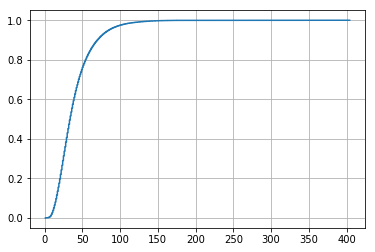

In [42]:
cdfplot(md['nsentences'])

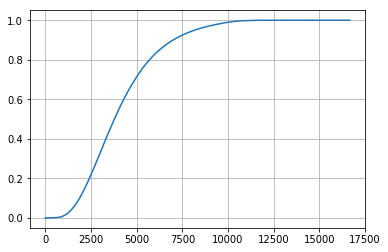

In [43]:
cdfplot(md['sentences_nchar'])

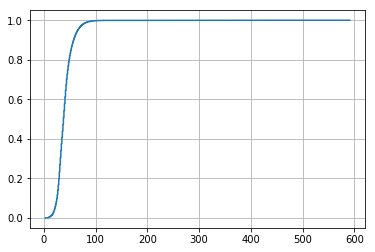

In [44]:
cdfplot(md['summary_ntokens'])